In [ ]:
import polars as pl
import numpy as np
from datetime import datetime, timedelta
import json

from data.cons_data import get_cons
from data.market_data import market_data

from utils.market_time import market_hours
from utils.params import PARAMS
from utils.clustering_methods import Clustering_methods

from pairs_finding.pairs_identification import cointegration_pairs
from pairs_finding.clustering import Clustering

from trade.pairs_trader import PairsTrader
from trade.optimizer import optimizer

import warnings

warnings.filterwarnings("ignore")

In [2]:
params = {
    ("GOOGL", "GOOG"): {
        PARAMS.beta_win: 100,
        PARAMS.beta_freq: "1d",  # TBC
        PARAMS.z_win: 10,
        PARAMS.z_entry: 2,
        PARAMS.z_exit: 1,
        PARAMS.trade_freq: "1m",
    },
    ("GOOGL", "AAPL"): {
        PARAMS.beta_win: 100,
        PARAMS.beta_freq: "1d",  # TBC
        PARAMS.z_win: 10,
        PARAMS.z_entry: 2,
        PARAMS.z_exit: 1,
        PARAMS.trade_freq: "5m",
    },
}

In [ ]:
etf = "QQQ"
cons = get_cons(etf=etf)
cons_date = cons.read()

data = market_data(
    file_path="C:/Users/edmun/OneDrive/Desktop/Quantitative Trading Strategies/Project/qts/data/"
)

earliest_date_year = [i for i in cons_date.keys() if int(i[:4]) >= 2018]

quarter_ends = (
    pl.DataFrame(earliest_date_year, schema=["Date"])
    .with_columns(pl.all().cast(pl.Date))
    .with_columns(
        pl.all().dt.quarter().alias("Quarter"),
        pl.all().dt.year().alias("Year"),
    )
    .group_by(["Quarter", "Year"], maintain_order=True)
    .last()["Date"]
    .dt.strftime("%Y-%m-%d")
    .to_list()
)

for i in range(2, 6):  # range(2, len(quarter_ends))
    train_start, train_end, trade_end = (
        quarter_ends[i - 2],
        quarter_ends[i - 1],
        quarter_ends[i],
    )

    print(train_start, train_end, trade_end)
    # TRAINING PERIOD FINDING OPTIMAL PARAMS #
    data.read(cons=cons_date[train_end], start=train_start, end=train_end)

    train = data.filter(resample_freq="1h", hours=market_hours.MARKET)

    c = Clustering(df=train.select(pl.all().exclude(["date", "time"])))

    c.run_clustering(method=Clustering_methods.kmeans, min_clusters=2, max_clusters=6)

    find_pairs = cointegration_pairs(
        df=train.select(pl.all().exclude(["date", "time"])),
        p_val_cutoff=0.1,
        cluster_pairs=c.cluster_pairs,
    )
    find_pairs.identify_pairs()

    trader = PairsTrader(
        data=data,
        pairs=[],  # list(params.keys()),  # pairs_to_trade
        params=None,
        trade_hour=market_hours.MARKET,
    )

    opt = optimizer(
        backtester=trader,
        find_pairs=find_pairs,  # list(params.keys()), # pairs_to_trade
        start=pl.lit(train_start).str.strptime(pl.Date, "%Y-%m-%d"),
        end=pl.lit(train_end).str.strptime(pl.Date, "%Y-%m-%d"),
    )

    p = opt.optimize(n_trials=50)

    optimal_params = {}
    for key, value in p.items():
        if key != "pairs_to_trade":
            parts = key.split("_")

            pair = (parts[0], parts[1])
            param_name = "_".join(parts[2:])

            if pair not in optimal_params:
                optimal_params[pair] = {}

            optimal_params[pair][param_name] = value

    # TRADING PERIOD USING PARAMS
    # next trading day
    last_date = datetime.strptime(train_end, "%Y-%m-%d")
    next_day = (last_date + timedelta(days=1)).strftime("%Y-%m-%d")

    # reading pairs only from next trading day to next q end
    pairs_to_trade = list(optimal_params.keys())
    data.read(
        cons=set([item for pair in pairs_to_trade for item in pair]),
        start=train_start,
        end=trade_end,
    )

    trader.pairs = pairs_to_trade
    trader.params = optimal_params
    trader.update_data(data=data)

    pl_next_day = pl.lit(next_day).str.strptime(pl.Date, "%Y-%m-%d")
    pl_trade_end = pl.lit(trade_end).str.strptime(pl.Date, "%Y-%m-%d")
    returns = trader.backtest(start=pl_next_day, end=pl_trade_end, cost=0.0005)

    returns.with_columns(
        pl.col("CAPITAL").pct_change().fill_null(0).alias("PORT_RET")
    ).write_csv(f"output/result_{next_day}_{trade_end}.csv")

    convert_json = {f"{p1}_{p2}": params for (p1, p2), params in optimal_params.items()}
    with open(f"output/optimal_params_{next_day}_{trade_end}.json", "w") as json_file:
        json.dump(convert_json, json_file, default=str)

    del c, opt, find_pairs, trader  # free ram

2018-03-29 2018-06-29 2018-09-28


  File "c:\Users\edmun\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\edmun\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\edmun\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\edmun\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[I 2025-05-25 20:39:31,088] A new study created in memory with name: no-name-026d03b9-614f-46e9-bc17-000531ab7367


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-25 20:39:37,535] Trial 0 finished with value: -5.537377106069319 and parameters: {'pairs_to_trade': 2, 'EXPE_ALGN_beta_win': 40, 'EXPE_ALGN_z_win': 65, 'EXPE_ALGN_z_entry': 0.2, 'EXPE_ALGN_z_exit': -1.0999999999999996, 'EXPE_ALGN_trade_freq': '15m', 'PAYX_EXPE_beta_win': 90, 'PAYX_EXPE_z_win': 40, 'PAYX_EXPE_z_entry': 2.9000000000000004, 'PAYX_EXPE_z_exit': -0.7999999999999998, 'PAYX_EXPE_trade_freq': '15m', 'VOD_HOLX_beta_win': 65, 'VOD_HOLX_z_win': 95, 'VOD_HOLX_z_entry': 1.0, 'VOD_HOLX_z_exit': -2.9, 'VOD_HOLX_trade_freq': '15m', 'HOLX_MELI_beta_win': 65, 'HOLX_MELI_z_win': 100, 'HOLX_MELI_z_entry': 2.3000000000000003, 'HOLX_MELI_z_exit': -2.9, 'HOLX_MELI_trade_freq': '15m'}. Best is trial 0 with value: -5.537377106069319.
[I 2025-05-25 20:39:37,997] Trial 1 finished with value: -4.221319640420511 and parameters: {'pairs_to_trade': 4, 'EXPE_ALGN_beta_win': 90, 'EXPE_ALGN_z_win': 55, 'EXPE_ALGN_z_entry': 1.5, 'EXPE_ALGN_z_exit': -1.5999999999999999, 'EXPE_ALGN_trade_freq':

[I 2025-05-25 20:40:17,179] A new study created in memory with name: no-name-69b54c72-684b-4638-8bbd-94d1f7f30a3d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-25 20:40:17,785] Trial 0 finished with value: -1.8548126032029983 and parameters: {'pairs_to_trade': 2, 'FB_EA_beta_win': 40, 'FB_EA_z_win': 65, 'FB_EA_z_entry': 0.2, 'FB_EA_z_exit': -1.0999999999999996, 'FB_EA_trade_freq': '15m', 'AVGO_MELI_beta_win': 90, 'AVGO_MELI_z_win': 40, 'AVGO_MELI_z_entry': 2.9000000000000004, 'AVGO_MELI_z_exit': -0.7999999999999998, 'AVGO_MELI_trade_freq': '15m', 'CELG_CERN_beta_win': 65, 'CELG_CERN_z_win': 95, 'CELG_CERN_z_entry': 1.0, 'CELG_CERN_z_exit': -2.9, 'CELG_CERN_trade_freq': '15m', 'PEP_BMRN_beta_win': 65, 'PEP_BMRN_z_win': 100, 'PEP_BMRN_z_entry': 2.3000000000000003, 'PEP_BMRN_z_exit': -2.9, 'PEP_BMRN_trade_freq': '15m'}. Best is trial 0 with value: -1.8548126032029983.
[I 2025-05-25 20:40:18,725] Trial 1 finished with value: -2.072942145192392 and parameters: {'pairs_to_trade': 4, 'FB_EA_beta_win': 90, 'FB_EA_z_win': 55, 'FB_EA_z_entry': 1.5, 'FB_EA_z_exit': -1.5999999999999999, 'FB_EA_trade_freq': '3m', 'AVGO_MELI_beta_win': 10, 'AVGO

[I 2025-05-25 20:41:10,667] A new study created in memory with name: no-name-a081bb05-0f75-49ba-a302-d55e225e065a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-25 20:41:11,490] Trial 0 finished with value: 0.1671781166858733 and parameters: {'pairs_to_trade': 2, 'MU_STX_beta_win': 40, 'MU_STX_z_win': 65, 'MU_STX_z_entry': 0.2, 'MU_STX_z_exit': -1.0999999999999996, 'MU_STX_trade_freq': '15m', 'NTES_SYMC_beta_win': 90, 'NTES_SYMC_z_win': 40, 'NTES_SYMC_z_entry': 2.9000000000000004, 'NTES_SYMC_z_exit': -0.7999999999999998, 'NTES_SYMC_trade_freq': '15m', 'CELG_CERN_beta_win': 65, 'CELG_CERN_z_win': 95, 'CELG_CERN_z_entry': 1.0, 'CELG_CERN_z_exit': -2.9, 'CELG_CERN_trade_freq': '15m', 'ISRG_FISV_beta_win': 65, 'ISRG_FISV_z_win': 100, 'ISRG_FISV_z_entry': 2.3000000000000003, 'ISRG_FISV_z_exit': -2.9, 'ISRG_FISV_trade_freq': '15m'}. Best is trial 0 with value: 0.1671781166858733.
[I 2025-05-25 20:41:12,896] Trial 1 finished with value: -1.7289034443276396 and parameters: {'pairs_to_trade': 4, 'MU_STX_beta_win': 90, 'MU_STX_z_win': 55, 'MU_STX_z_entry': 1.5, 'MU_STX_z_exit': -1.5999999999999999, 'MU_STX_trade_freq': '3m', 'NTES_SYMC_beta_w

[I 2025-05-25 20:42:14,080] A new study created in memory with name: no-name-b11e7050-3619-4805-b07c-114302661f9f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-25 20:42:15,388] Trial 0 finished with value: 0.9775779265646564 and parameters: {'pairs_to_trade': 2, 'TTWO_SYMC_beta_win': 40, 'TTWO_SYMC_z_win': 65, 'TTWO_SYMC_z_entry': 0.2, 'TTWO_SYMC_z_exit': -1.0999999999999996, 'TTWO_SYMC_trade_freq': '15m', 'MU_WDC_beta_win': 90, 'MU_WDC_z_win': 40, 'MU_WDC_z_entry': 2.9000000000000004, 'MU_WDC_z_exit': -0.7999999999999998, 'MU_WDC_trade_freq': '15m', 'INTC_AMGN_beta_win': 65, 'INTC_AMGN_z_win': 95, 'INTC_AMGN_z_entry': 1.0, 'INTC_AMGN_z_exit': -2.9, 'INTC_AMGN_trade_freq': '15m', 'GILD_BMRN_beta_win': 65, 'GILD_BMRN_z_win': 100, 'GILD_BMRN_z_entry': 2.3000000000000003, 'GILD_BMRN_z_exit': -2.9, 'GILD_BMRN_trade_freq': '15m', 'XLNX_WDAY_beta_win': 75, 'XLNX_WDAY_z_win': 90, 'XLNX_WDAY_z_entry': 1.8, 'XLNX_WDAY_z_exit': -2.0, 'XLNX_WDAY_trade_freq': '5m', 'AMD_LULU_beta_win': 50, 'AMD_LULU_z_win': 10, 'AMD_LULU_z_entry': 0.2, 'AMD_LULU_z_exit': -2.5, 'AMD_LULU_trade_freq': '3m'}. Best is trial 0 with value: 0.9775779265646564.
[I 202

In [4]:
import polars as pl
import glob

dfs = [pl.read_csv(file) for file in glob.glob("output/*.csv")]
df = pl.concat(dfs, how="diagonal")

<Axes: >

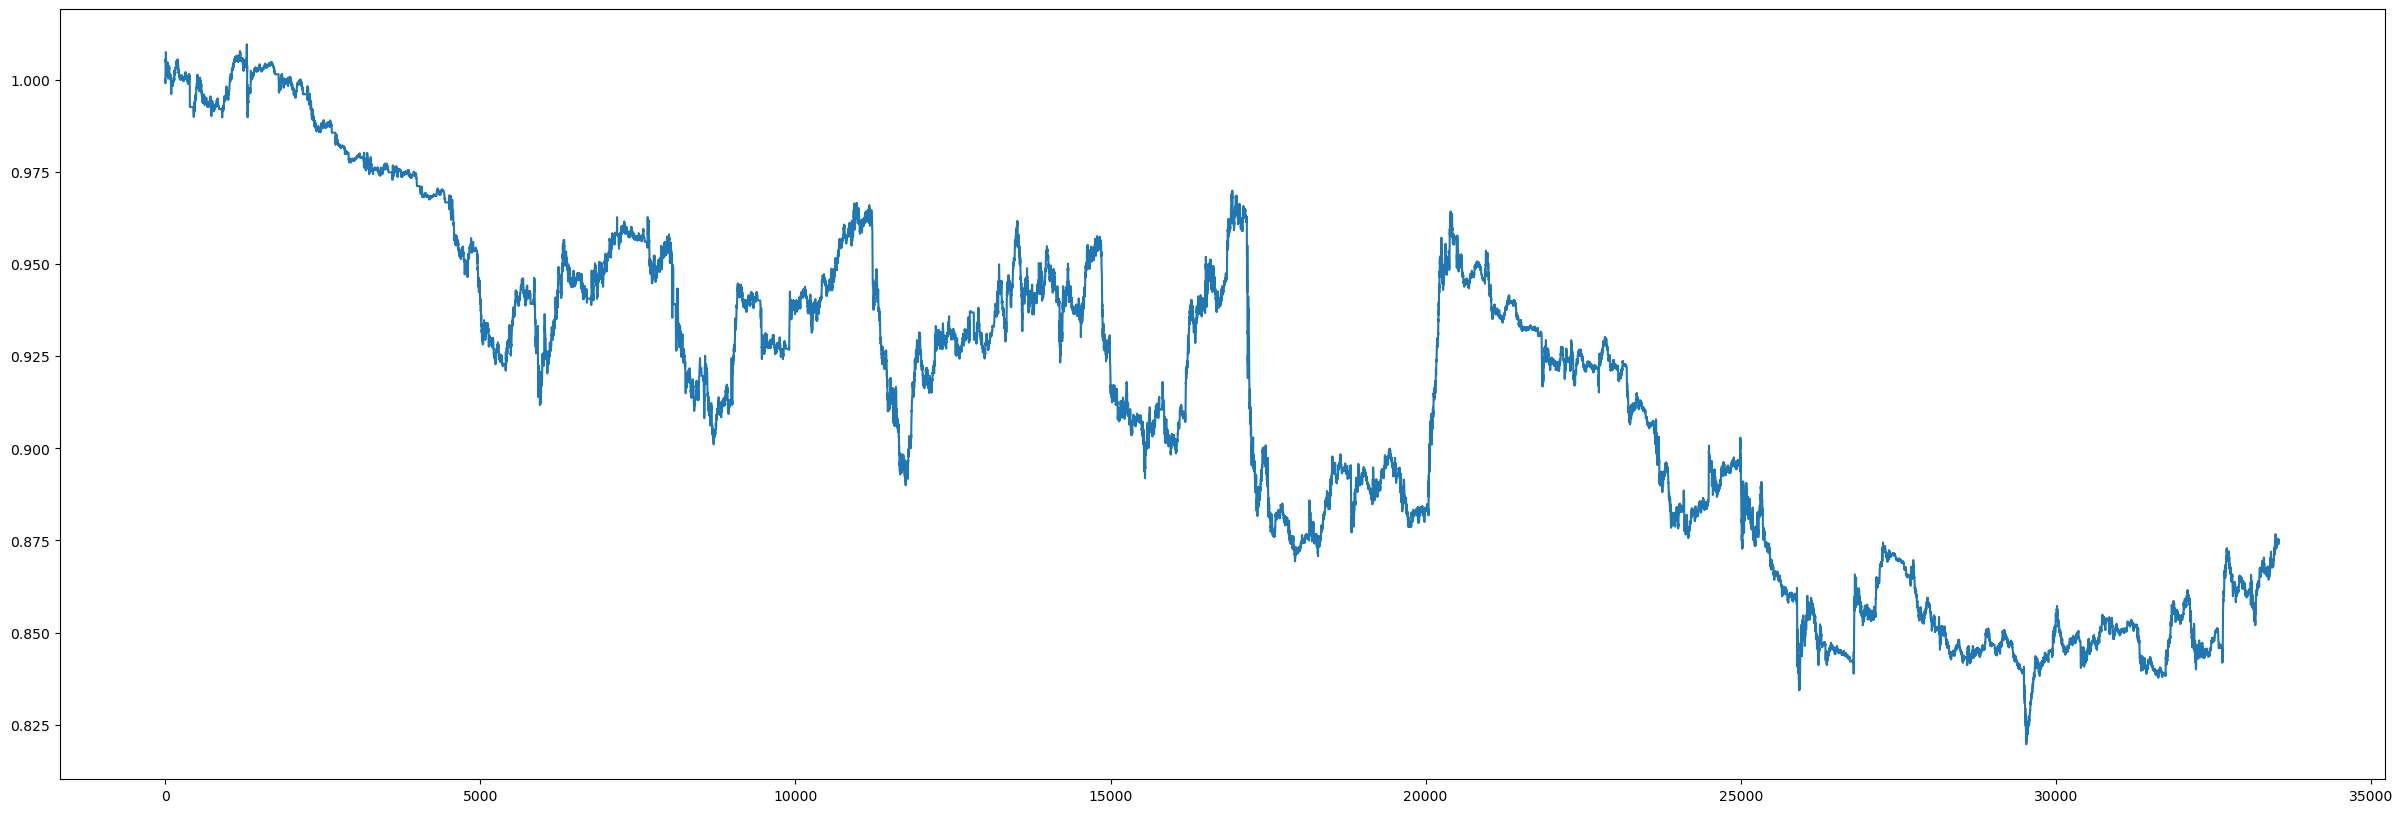

In [5]:
(df["PORT_RET"] + 1).to_pandas().cumprod().plot(figsize=(30, 10))

<Axes: >

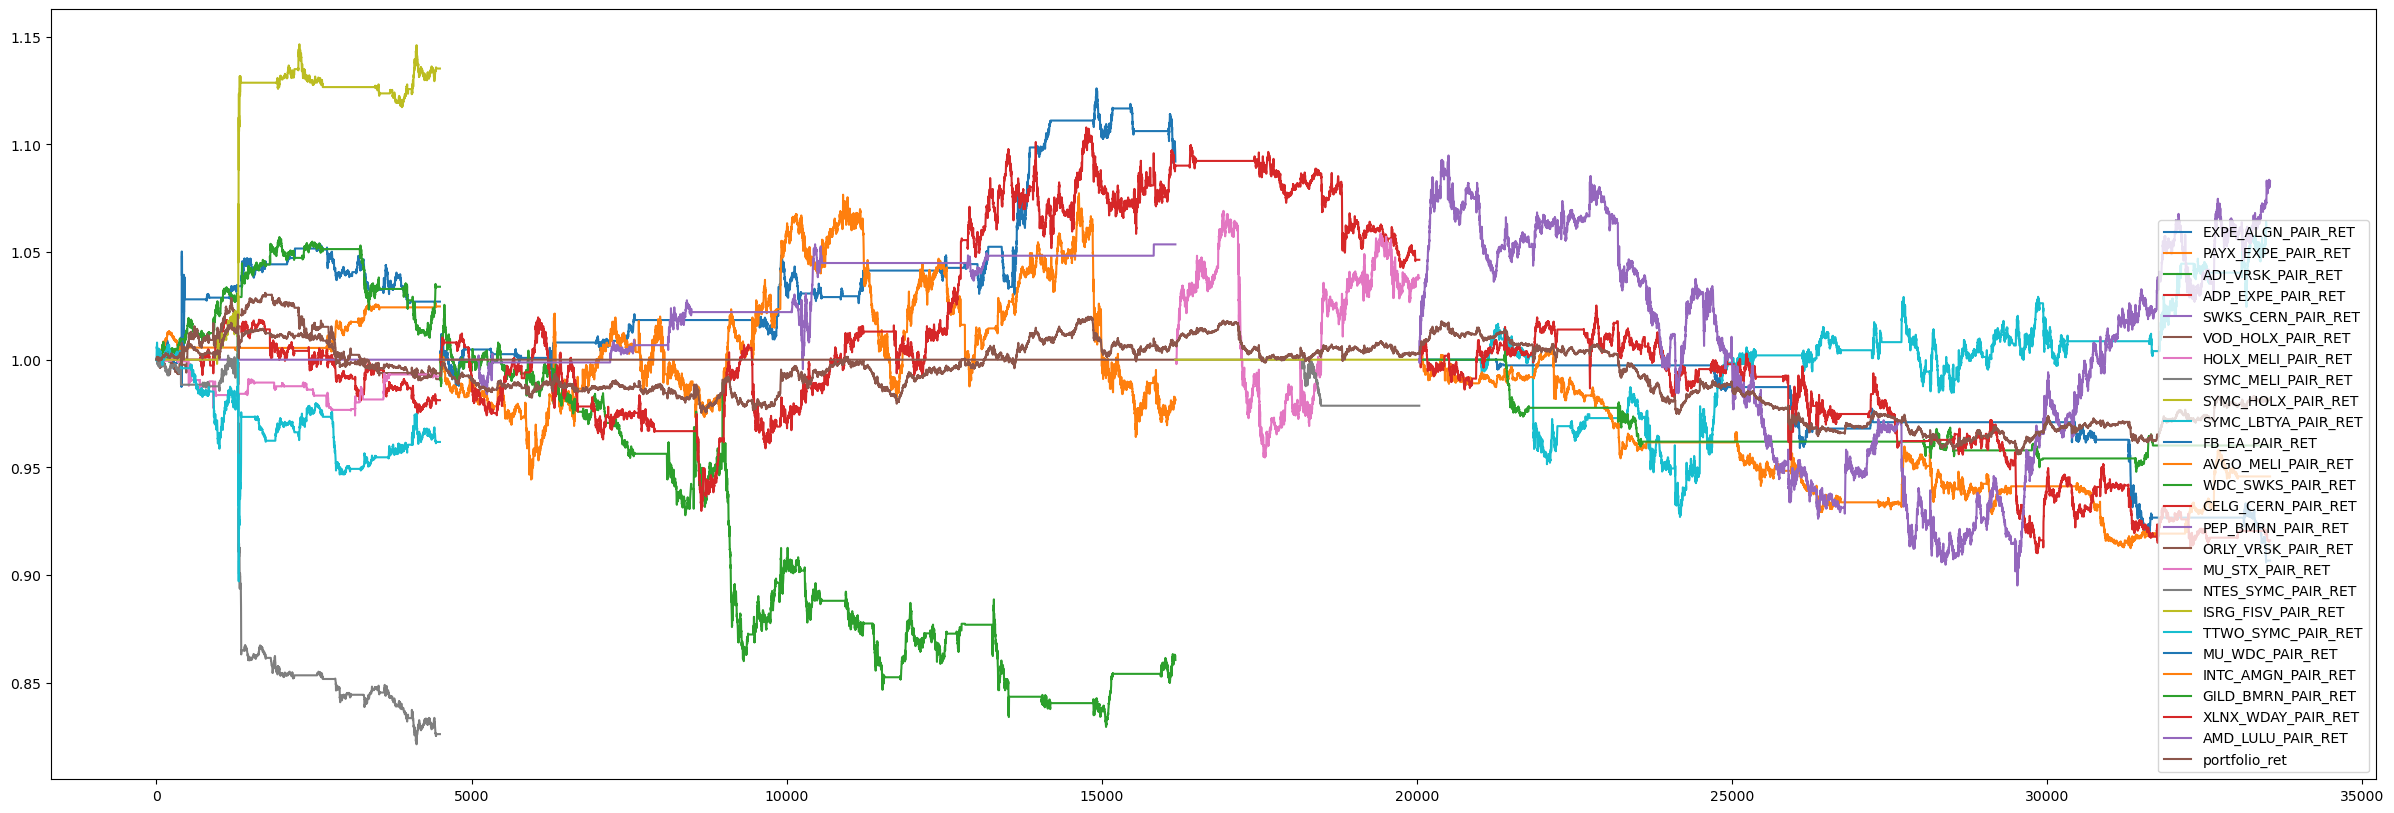

In [6]:
(
    df.select([col for col in df.columns if "_PAIR_RET" in col]).with_columns(
        pl.sum_horizontal(
            pl.all().exclude(["date", "time"]) * 1 / len(list(optimal_params.keys()))
        ).alias("portfolio_ret")
    )
    + 1
).to_pandas().cumprod().plot(figsize=(30, 10))

In [ ]:
bt_df = (
    df.select('PORT_RET')
    .fill_null(0)
    .to_numpy()
    .flatten()
)

sharpe = np.mean(bt_df) / np.std(bt_df) * np.sqrt(390 * 252)
print("SHARPE: ", sharpe)

SHARPE:  -1.356822444540973


In [8]:
np.cumprod(bt_df + 1)

array([1.        , 0.9995    , 0.99901843, ..., 0.8740816 , 0.87468555,
       0.87513859])